In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Определение эмоциональной окраски твитов с помощью BERT

In [2]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

## Установка библиотек

In [3]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 291 kB/s            


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [6]:
import pandas as pd

!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!mkdir ./stepik-dl-nlp/datasets/bert_sentiment_analysis/

!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/bert_sentiment_analysis/positive.csv" \
    -o ./stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/bert_sentiment_analysis/negative.csv" \
    -o ./stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('./stepik-dl-nlp/datasets/bert_sentiment_analysis/negative.csv', encoding='utf8', sep=';', header=None)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.0M  100 25.0M    0     0  10.6M      0  0:00:02  0:00:02 --:--:-- 10.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.3M  100 23.3M    0     0  10.1M      0  0:00:02  0:00:02 --:--:-- 10.1M


In [7]:
#Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?
import re
pos_texts[3] = pd.Series([re.sub(r':D|D:|[^\w\s]', '', line) for line in list(pos_texts[3])])
neg_texts[3] = pd.Series([re.sub(r':D|D:|[^\w\s]', '', line) for line in list(neg_texts[3])])

In [8]:
pos_texts.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11
103799,411115031041159169,1386852436,moqacykaryqa,Пойду я спать снедаемая грустными думами и ком...,1,0,0,0,872,224,250,0
47245,410005806546157568,1386587976,knowlesjeff96,RT Cibrenco katyalukinova nastasorokina shramk...,1,0,3,0,161,303,296,0
33941,409762184408072192,1386529892,gorohova99,три вещи которые обязательно возьмешь в поход ...,1,0,0,0,5265,24,22,1
92669,410863523518881792,1386792472,Karishel_98,NikRomantika за правду спасибо не говарятне за...,1,0,0,0,660,67,69,0
83007,410771525680123904,1386770538,UriyLubimov,Думаю опять начать засорять вашу ленту в твитт...,1,0,0,0,2914,58,44,0


In [9]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [10]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [11]:
print(sentences[1000])

[CLS] Дим ты помогаешь мне я тебе все взаимно все правильно [SEP]


In [12]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [13]:
print(len(train_gt), len(test_gt))

158783 68051


## Inputs

In [14]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 320782.46B/s]


['[CLS]', 'vest', '##i', '_', 'k', '##ps', '##s', 'э', '##т', '##о', 'с', '##л', '##о', '##ж', '##н', '##о', 'и', 'д', '##о', '##л', '##г', '##о', '##а', 'у', 'м', '##е', '##н', '##я', 'е', '##щ', '##е', 'и', 'г', '##л', '##у', '##п', '##о', '##н', '##у', '##д', '##н', '##о', 'и', 'н', '##а', '##и', '##в', '##н', '##о', 'п', '##о', '##л', '##у', '##ч', '##и', '##т', '##с', '##я', '[SEP]']


BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [15]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [16]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [17]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [18]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [19]:
train_labels

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [20]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [21]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [22]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [23]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

100%|██████████| 440473133/440473133 [00:39<00:00, 11110204.12B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



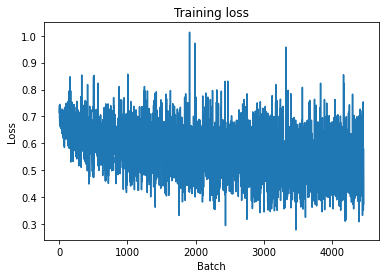

Loss на обучающей выборке: 0.56662
Процент правильных предсказаний на валидационной выборке: 74.02%


In [26]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [27]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 74.02%


# Оценка качества на отложенной выборке

In [28]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [29]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [30]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [31]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 74.18%


In [32]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(np.array(test_labels) != np.array(test_preds)),
    len(test_labels)
))

Неправильных предсказаний: 17569/68051


### Задание. Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?

In [33]:
list(pos_texts[3])[:10]

['first_timee хоть я и школота но поверь у нас то же самое  общество профилирующий предмет типа',
 'Да всетаки он немного похож на него Но мой мальчик все равно лучше',
 'RT KatiaCheh Ну ты идиотка я испугалась за тебя',
 'RT digger2912 Кто то в углу сидит и погибает от голода а мы ещё 2 порции взяли хотя уже и так жрать не хотим D httptcoGqG6iuE2',
 'irina_dyshkant Вот что значит страшилка \nНо блинпосмотрев все частиу тебя создастся ощущениечто авторы курили чтото ',
 'ну любишь или нет  Я не знаю кто ты бля httptcobrf9eNg1U6',
 'RT SpoonLamer Ох900  ну это конечно же twinkleAYO  Чтобы у нее было много друзей ведь она такая мимими lt3',
 'RT veregijytaqo У тебя есть ухажёр Нет  мои уши не кто не жрёт ',
 'Поприветствуем моего нового читателя Alexey1789 ',
 'Теперь у меня есть частичка Сиднея  Sydney SydneyOperaHouse httptcoagnto3CZEi']

In [34]:
len([line for line in list(pos_texts[3]) if (")" in line) or ":D" in line])/len(list(pos_texts[3]))

0.0

In [35]:
list(neg_texts[3])[:50]

['на работе был полный пиддес  и так каждое закрытие месяца я же свихнусь так ',
 'Коллеги сидят рубятся в Urban terror а я изза долбанной винды не могу ',
 'elina_4post как говорят обещаного три года ждут',
 'Желаю хорошего полёта и удачной посадкия буду очень сильно скучать httptcojCLNzVNv3S',
 'Обновил за какимто лешим surf теперь не работает простоплеер ',
 'Котёнка вчера носик разбила плакала и расстраивалась ',
 'juliamayko O_nika55 and_Possum Зашли а то он опять затихарился я прямо физически страдаю когда он долго молчит',
 'а вообще я не болею   я не выздоравливаю ',
 'я микрофраза  учимся срать кирпичами в режиме ampquotнонстопampquot niwoqisipapy',
 'я хочу с тобой помириться  но сука я гордая и никогда этого не сделаю ',
 'DNO_OKEANA_A3A3 MOE_MOPE_A3A3 тебя ебет какие у меня фоткия про твои молчуи вообще ты хоть знаешь как ТП то выглядят',
 'Блин начали сниться сны Не когда почти не снились  А теперь можно сказать каждый день такое  Мне это не нравиться ',
 'realVold На твое

In [36]:
len([line for line in list(neg_texts[3]) if ("(" in line) or "D:" in line])/len(list(pos_texts[3]))

0.0

### Задание. Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?

In [37]:
import re
pos_texts = [re.sub(r':D|D:|[^\w\s]', '', line) for line in list(pos_texts[3])]
neg_texts = [re.sub(r':D|D:|[^\w\s]', '', line) for line in list(neg_texts[3])]

### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 